In [54]:
import requests as r
from time import sleep
import pickle
from random import choice
from tqdm.notebook import tqdm
from IPython.display import IFrame
import pandas as pd

# Load all catalog pages

In [2]:
def get_page(n):
    addr = 'https://api.remanga.org/api/search/catalog/'
    res = r.get(addr, params={'ordering': '-rating',
                          'page': n,
                          'count': 300})
    assert res.status_code == 200
    return res.json()

In [4]:
items = []

In [5]:
for page_n in tqdm(range(1, 59)):
    json_items = get_page(page_n)['content']
    items += json_items
    sleep(1.0)

100%|██████████| 58/58 [01:29<00:00,  1.54s/it]


# Create dataframe

In [6]:
items[0]

{'id': 2060,
 'en_name': 'Solo Leveling',
 'rus_name': 'Поднятие уровня в одиночку',
 'dir': 'solo-leveling',
 'issue_year': 2018,
 'avg_rating': '9.6',
 'type': 'Манхва',
 'total_views': 9546754,
 'total_votes': 1210457,
 'cover_high': 'titles/solo-leveling/3d99c504bdc727e34d12eb945f09e30a.jpg',
 'cover_mid': 'titles/solo-leveling/60da630a4154ad4ab38883d37d38a7b7.jpg',
 'cover_low': 'titles/solo-leveling/8dfa20a69789960015a39778536ab507.jpg',
 'bookmark_type': None,
 'genres': [{'id': 2, 'name': 'Боевик'},
  {'id': 12, 'name': 'Игра'},
  {'id': 16, 'name': 'Элементы юмора'},
  {'id': 23, 'name': 'Приключения'},
  {'id': 25, 'name': 'Романтика'},
  {'id': 30, 'name': 'Сёнэн'},
  {'id': 38, 'name': 'Фэнтези'}],
 'img': {'high': '/media/titles/solo-leveling/3d99c504bdc727e34d12eb945f09e30a.jpg',
  'mid': '/media/titles/solo-leveling/60da630a4154ad4ab38883d37d38a7b7.jpg',
  'low': '/media/titles/solo-leveling/8dfa20a69789960015a39778536ab507.jpg'},
 'categories': [{'id': 5, 'name': 'Веб'}

In [12]:
cols = ['rus_name', 'en_name', 'issue_year', 'avg_rating', 'total_views', 'total_votes', 'type', 'dir']

def get_info(manga):
    fields = [manga[c] for c in cols]
    return fields

In [13]:
get_info(items[0])

['Поднятие уровня в одиночку',
 'Solo Leveling',
 2018,
 '9.6',
 9546754,
 1210457,
 'Манхва',
 'solo-leveling']

In [14]:
parsed_items = list(map(get_info, items))
df = pd.DataFrame(columns=cols, data=parsed_items)
df.loc[:, 'avg_rating'] = df.avg_rating.astype(float)
df.head()

,rus_name,en_name,issue_year,avg_rating,total_views,total_votes,type,dir
0,Поднятие уровня в одиночку,Solo Leveling,2018.0,9.6,9546754,1210457,Манхва,solo-leveling
1,Начало после конца,The Beginning After the End,2018.0,9.6,6130139,1172388,Западный комикс,the_beginning_after_the_end
2,Пик боевых искусств,Martial Peak,2018.0,8.7,25303479,3640188,Маньхуа,martial_peak
3,Герой иного мнения,Hero with another opinion,2020.0,9.2,458051,111061,Рукомикс,hero-with-another-opinion
4,"Ранкер, который живёт второй раз",Ranker who lives a second time,2019.0,9.3,3009313,531178,Манхва,ranker-who-lives-a-second-time


In [18]:
df.to_csv('data/remanga_catalog_mangas.csv', index=False)

# Load info about title's chapters

In [34]:
def get_manga(d):
    addr = 'https://api.remanga.org/api/titles/'
    res = r.get(addr + d)
#     if res.status_code == 200:
#         print('[WARN] status_code=%d on %s' % (res.status_code, d))
    assert res.status_code == 200
    return res.json()

In [52]:
addrs = [item['dir'] for item in items]
raw_mangas = []
bar = tqdm(addrs)
for manga in bar:
    try:
        page = get_manga(manga)
        raw_mangas.append(page)
    except AssertionError:
        raw_mangas.append(None)
        
    n_fails = len(list(filter(lambda m: m is None, raw_mangas)))
    bar.set_postfix_str(f"Fails {round(n_fails/len(addrs), 2)} ({n_fails})")
    
    sleep(0.2)

In [56]:
pickle.dump(raw_mangas, open('data/remanga_raw_titles.pkl', 'wb'))

In [62]:
def fetch_chapters_n(manga):
    if manga is None:
        return None
    return manga['content']['count_chapters']

In [63]:
chapters = list(map(fetch_chapters_n, raw_mangas))
df.loc[:, 'n_chapters'] = chapters

<AxesSubplot:>

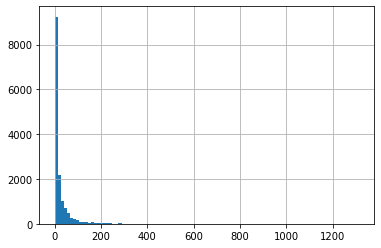

In [67]:
df.n_chapters.hist(bins=100)

In [69]:
df.to_csv('data/remanga_catalog_mangas.csv', index=False)

278                         sun_ken_rock
288      dad-im-not-going-to-get-married
352        please_dont_bully_me_nagatoro
358                     kill-the-villain
370                      evil-ladys-hero
                      ...               
16329                   become-her-bride
16337                     moon-star-june
16485                captured-by-passion
16675                      kishidou-club
16682                black-cat-of-matter
Name: dir, Length: 2041, dtype: object